# Weighted ML external

In [4]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create synthetic data
np.random.seed(42)
X = np.random.rand(100, 3)
y = X[:, 0] * 10 + np.random.randn(100) * 2  # True relationship with noise

# Add outliers
y[::10] += np.random.randn(10) * 20

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate IQR for target values
q1 = np.percentile(y_train, 25)
q3 = np.percentile(y_train, 75)
iqr = q3 - q1

# Assign weights: higher for IQR, lower for outliers
weights = np.where((y_train >= q1) & (y_train <= q3), 2.0, 0.5)

# Initialize models
model_no_weights = CatBoostRegressor(verbose=False, random_seed=42)
model_with_weights = CatBoostRegressor(verbose=False, random_seed=42)

# Train models
model_no_weights.fit(X_train, y_train)
model_with_weights.fit(X_train, y_train, sample_weight=weights)

# Evaluate models
y_pred_no_weights = model_no_weights.predict(X_test)
y_pred_with_weights = model_with_weights.predict(X_test)

mae_no_weights = mean_absolute_error(y_test, y_pred_no_weights)
mae_with_weights = mean_absolute_error(y_test, y_pred_with_weights)

mse_no_weights = mean_squared_error(y_test, y_pred_no_weights)
mse_with_weights = mean_squared_error(y_test, y_pred_with_weights)

# Print results
print("Without Weights - MAE:", mae_no_weights, "MSE:", mse_no_weights)
print("With Weights (IQR emphasis) - MAE:", mae_with_weights, "MSE:", mse_with_weights)


Without Weights - MAE: 4.134130099210053 MSE: 33.664516084598574
With Weights (IQR emphasis) - MAE: 4.1783387010239235 MSE: 32.654668027647716


Without Weights (Equal Importance):
MAE: 4.7205 | MSE: 72.7540 | RMSE: 8.5296 | R²: 0.9696

With Weights (Extreme Emphasis):
MAE: 5.1142 | MSE: 79.5189 | RMSE: 8.9173 | R²: 0.9668


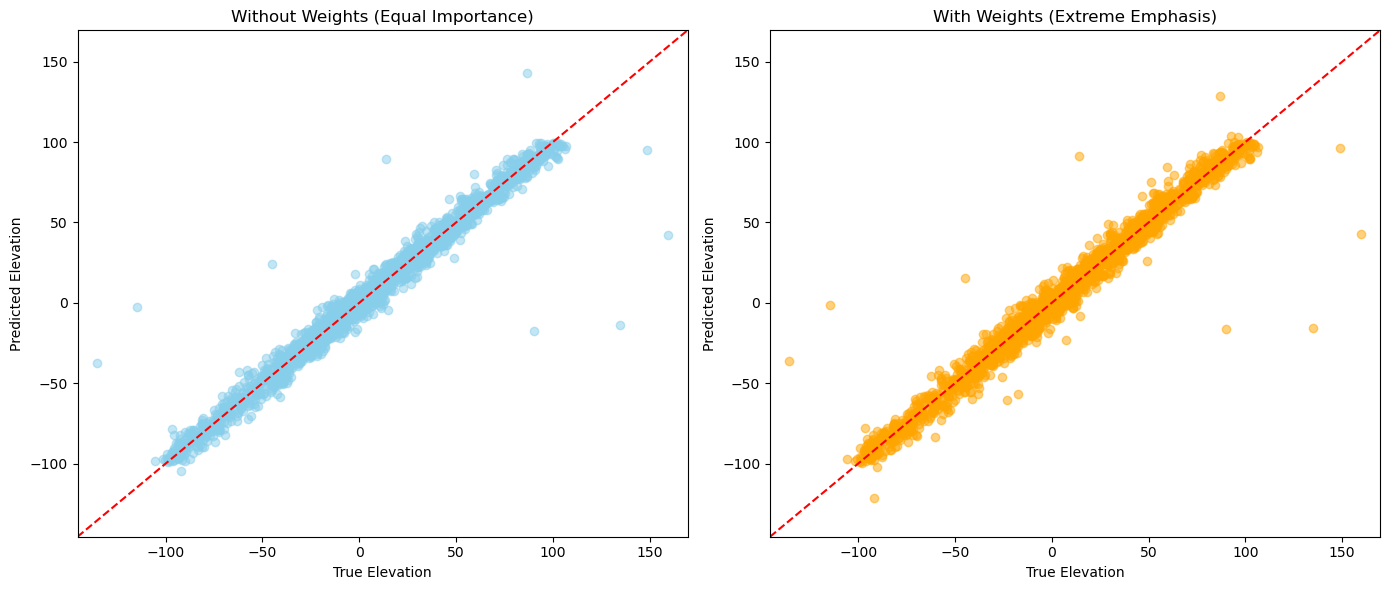

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic DEM-like data (10,000 samples, 3 spatial features)
X = np.random.rand(10000, 3) * 100  # Simulating spatial coordinates
# Generate elevation data with sinusoidal + noise for terrain-like undulation
y = (np.sin(X[:, 0] / 10) + np.cos(X[:, 1] / 10)) * 50 + np.random.randn(10000) * 5

# Introduce extreme peaks and valleys (outliers)
y[::300] += np.random.randn(34) * 100  # Extreme peaks
y[::400] -= np.random.randn(25) * 100  # Extreme valleys

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate high and low quantiles for extreme cases
q_low, q_high = np.percentile(y_train, [10, 90])

# Create sample weights: Emphasize extreme values (top/bottom 10%)
weights = np.where((y_train <= q_low) | (y_train >= q_high), 2.0, 0.5)

# Initialize CatBoost models
model_no_weights = CatBoostRegressor(verbose=False, random_seed=42)
model_with_weights = CatBoostRegressor(verbose=False, random_seed=42)

# Train models
model_no_weights.fit(X_train, y_train)
model_with_weights.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred_no_weights = model_no_weights.predict(X_test)
y_pred_with_weights = model_with_weights.predict(X_test)

# Define evaluation metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Evaluate both models
metrics_no_weights = evaluate(y_test, y_pred_no_weights)
metrics_with_weights = evaluate(y_test, y_pred_with_weights)

# Print results
print("Without Weights (Equal Importance):")
print(f"MAE: {metrics_no_weights[0]:.4f} | MSE: {metrics_no_weights[1]:.4f} | "
      f"RMSE: {metrics_no_weights[2]:.4f} | R²: {metrics_no_weights[3]:.4f}")

print("\nWith Weights (Extreme Emphasis):")
print(f"MAE: {metrics_with_weights[0]:.4f} | MSE: {metrics_with_weights[1]:.4f} | "
      f"RMSE: {metrics_with_weights[2]:.4f} | R²: {metrics_with_weights[3]:.4f}")

# Plot predictions vs. true values
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
lims = [min(y_test) - 10, max(y_test) + 10]

# No weights plot
ax[0].scatter(y_test, y_pred_no_weights, alpha=0.5, color='skyblue')
ax[0].plot(lims, lims, 'r--')  # Ideal prediction line
ax[0].set_title("Without Weights (Equal Importance)")
ax[0].set_xlabel("True Elevation")
ax[0].set_ylabel("Predicted Elevation")
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)

# With weights plot
ax[1].scatter(y_test, y_pred_with_weights, alpha=0.5, color='orange')
ax[1].plot(lims, lims, 'r--')  # Ideal prediction line
ax[1].set_title("With Weights (Extreme Emphasis)")
ax[1].set_xlabel("True Elevation")
ax[1].set_ylabel("Predicted Elevation")
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)

plt.tight_layout()
plt.show()


Without Weights (Equal Importance):
MAE: 4.7205 | MSE: 72.7540 | RMSE: 8.5296 | R²: 0.9696

With Weights (IQR Emphasis):
MAE: 4.6755 | MSE: 68.0630 | RMSE: 8.2500 | R²: 0.9716


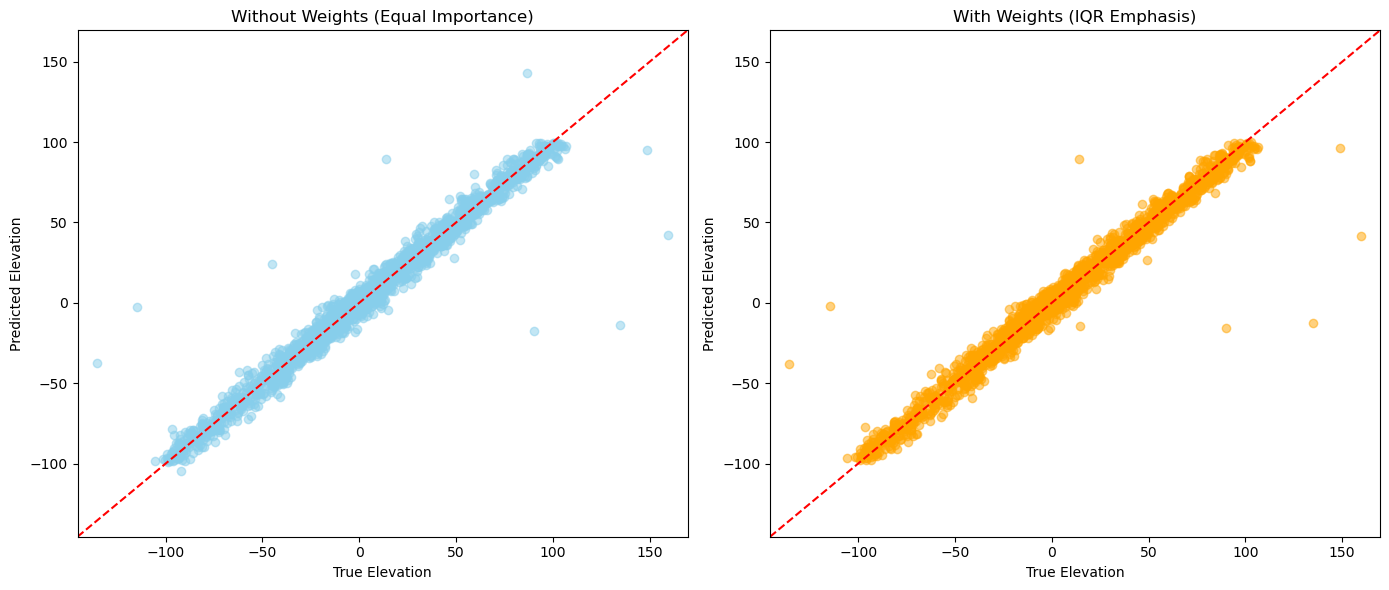

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic DEM-like data (10,000 samples, 3 spatial features)
X = np.random.rand(10000, 3) * 100  # Simulating spatial coordinates
# Generate elevation data with sinusoidal + noise for terrain-like undulation
y = (np.sin(X[:, 0] / 10) + np.cos(X[:, 1] / 10)) * 50 + np.random.randn(10000) * 5

# Introduce extreme peaks and valleys (outliers)
y[::300] += np.random.randn(34) * 100  # Extreme peaks
y[::400] -= np.random.randn(25) * 100  # Extreme valleys

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate IQR for y_train
q1, q3 = np.percentile(y_train, [2, 85]) #hpo 2, 80
iqr_mask = (y_train >= q1) & (y_train <= q3)

# Create sample weights: Emphasize non-extremes (IQR)
weights = np.where(iqr_mask, 2.0, 0.5) #hpo  2.0, 0.5

# Initialize CatBoost models
model_no_weights = CatBoostRegressor(verbose=False, random_seed=42)
model_with_weights = CatBoostRegressor(verbose=False, random_seed=42)

# Train models
model_no_weights.fit(X_train, y_train)
model_with_weights.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred_no_weights = model_no_weights.predict(X_test)
y_pred_with_weights = model_with_weights.predict(X_test)

# Define evaluation metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Evaluate both models
metrics_no_weights = evaluate(y_test, y_pred_no_weights)
metrics_with_weights = evaluate(y_test, y_pred_with_weights)

# Print results
print("Without Weights (Equal Importance):")
print(f"MAE: {metrics_no_weights[0]:.4f} | MSE: {metrics_no_weights[1]:.4f} | "
      f"RMSE: {metrics_no_weights[2]:.4f} | R²: {metrics_no_weights[3]:.4f}")

print("\nWith Weights (IQR Emphasis):")
print(f"MAE: {metrics_with_weights[0]:.4f} | MSE: {metrics_with_weights[1]:.4f} | "
      f"RMSE: {metrics_with_weights[2]:.4f} | R²: {metrics_with_weights[3]:.4f}")

# Plot predictions vs. true values
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
lims = [min(y_test) - 10, max(y_test) + 10]

# No weights plot
ax[0].scatter(y_test, y_pred_no_weights, alpha=0.5, color='skyblue')
ax[0].plot(lims, lims, 'r--')  # Ideal prediction line
ax[0].set_title("Without Weights (Equal Importance)")
ax[0].set_xlabel("True Elevation")
ax[0].set_ylabel("Predicted Elevation")
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)

# With weights plot
ax[1].scatter(y_test, y_pred_with_weights, alpha=0.5, color='orange')
ax[1].plot(lims, lims, 'r--')  # Ideal prediction line
ax[1].set_title("With Weights (IQR Emphasis)")
ax[1].set_xlabel("True Elevation")
ax[1].set_ylabel("Predicted Elevation")
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)

plt.tight_layout()
plt.show()


In [19]:
# yes this one holds... go on 
# explanation:https://www.restack.io/docs/mlflow-knowledge-xgboost-regression-sample-weight-mlflow

In [10]:
weights

array([2. , 2. , 0.5, ..., 0.5, 2. , 2. ])

In [12]:
np.unique(weights)

array([0.5, 2. ])